In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy


from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

import pymorphy3
import re

from transformers import AutoTokenizer
from transformers import TFAutoModel

import tensorflow as tf

from keras_preprocessing.sequence import pad_sequences


from keras.layers import LSTM, Embedding, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import Sequential
from keras.models import save_model, load_model

In [2]:
def remove_stopwords(text, stoplist):
    return [word for word in text if word not in stoplist]


def remove_punctuation(text):
    punctuation = string.punctuation
    return ''.join([c if c not in punctuation else ' ' for c in text])


def remove_spaces(text):
    return re.sub(r'\s+', ' ', text)


def clean_text(data):
    cleaned_text = [remove_punctuation(remove_spaces(str(text).lower())) for text in data['text']]
    data['text'] = cleaned_text
    return data

In [3]:
def lemmatize_text(data):
    min_length = 2
    stoplist = stopwords.words("russian")
    morph = pymorphy3.MorphAnalyzer(lang='ru')  # 'fix'
    lemmatized_text = []
    for text in data['text']:
        text_lem = [morph.parse(word)[0].normal_form for word in text.split(' ')]
        text_lem = remove_stopwords(text_lem, stoplist)

    if len(text_lem) > min_length:
        lemmatized_text.append(' '.join(text_lem))
    else:
        lemmatized_text.append('')
    data['text'] = lemmatized_text
    return data

def tokenize_text(data):
    tokens = tokenizer.encode_plus(data, max_length = max_article_length,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [4]:
def load_unprocessed_text_to_df():
    filename = "lenta-ru-train.csv"
    data = pd.read_csv(filename, index_col=False, encoding="utf8", nrows=10000)
    df = pd.DataFrame(data)
    df['text'] = df['title'].str.ljust(1) + df['text']
    df = df.drop(['topic', 'title'], axis=1)
    return df


In [5]:
def load_processed_text_to_df():
    filename = "lenta-ru-clean-20k.csv"
    data = pd.read_csv(filename, index_col=False, encoding="utf8", nrows=10000)
    df = pd.DataFrame(data) 
    return df

In [6]:
#text = load_unprocessed_text_to_df()
#text = clean_text(text)
#text = lemmatize_text(text)
#text.to_csv(lenta-ru-clean-20k.csv)

In [7]:
max_article_length = 512

In [8]:
text = load_processed_text_to_df()
text.head()

,Unnamed: 0,text,topic_label
0,0,инфляция январь 2006 год составить 2 6 процент...,0
1,1,никита михалков учредить день российский киноу...,3
2,2,марко матерацци вернуться строй матч цскамедиц...,1
3,3,определить лауреат премия книга год премия к...,3
4,4,гол роналда штрафной спасти португалец поражен...,1


In [9]:
train, test_val = train_test_split(text, test_size=0.5,  random_state = 0)
test, val = train_test_split(test_val, test_size=0.4,  random_state = 0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

In [10]:
text_id = np.zeros((len(train), max_article_length))
text_masks = np.zeros((len(train), max_article_length))

test_id = np.zeros((len(test), max_article_length))
test_masks = np.zeros((len(test), max_article_length))


val_id = np.zeros((len(val), max_article_length))
val_masks = np.zeros((len(val), max_article_length))

In [11]:
tokenizer = AutoTokenizer.from_pretrained("Geotrend/bert-base-ru-cased")
for i in range(len(train)):
    tokens = tokenize_text(train['text'][i])
    text_id[i], text_masks[i] = tokens[0], tokens[1]


for i in range(len(test)):
    tokens = tokenize_text(test['text'][i])
    test_id[i], test_masks[i] = tokens[0], tokens[1]

for i in range(len(val)):
    tokens = tokenize_text(val['text'][i])
    val_id[i], val_masks[i] = tokens[0], tokens[1]


In [12]:
Y_test = test['topic_label']
Y_train = train['topic_label']
Y_val = val['topic_label']

In [13]:
bert = TFAutoModel.from_pretrained("Geotrend/bert-base-ru-cased")

Some layers from the model checkpoint at Geotrend/bert-base-ru-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Geotrend/bert-base-ru-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  97010688  
                                                                 
Total params: 97,010,688
Trainable params: 97,010,688
Non-trainable params: 0
_________________________________________________________________


In [15]:
tf.config.experimental.get_memory_info('GPU:0')['current']

400071680

In [16]:
input_layer = tf.keras.layers.Input(shape=(max_article_length,), name='input', dtype='int32')
mask = tf.keras.layers.Input(shape=(max_article_length,), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_layer, attention_mask=mask)[1]


x = tf.keras.layers.Dense(128, activation ='relu')(embeddings)
y = tf.keras.layers.Dense(6, activation ='softmax', name='output')(x)

model = tf.keras.Model(inputs=[input_layer, mask], outputs=y)

model.layers[2].trainable = False

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  97010688    ['input[0][0]',                  
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [18]:
tf.config.experimental.get_memory_info('GPU:0')['current']

400469760

In [19]:
model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [20]:
batch_size = 16

In [21]:
history = model.fit(
    [text_id, text_masks], Y_train,
    batch_size = 16,
    verbose = 1,
    validation_data = ([val_id, val_masks], Y_val),
    epochs=15,
    steps_per_epoch = 50,
    validation_steps = 15)

Epoch 1/15
50/50 [==============================] - 148s 3s/step - loss: 1.4888 - accuracy: 0.3375 - val_loss: 1.3003 - val_accuracy: 0.3542
Epoch 2/15
50/50 [==============================] - 127s 3s/step - loss: 1.2037 - accuracy: 0.5387 - val_loss: 1.0901 - val_accuracy: 0.6208
Epoch 3/15
50/50 [==============================] - 127s 3s/step - loss: 1.0957 - accuracy: 0.6087 - val_loss: 0.9529 - val_accuracy: 0.6667
Epoch 4/15
50/50 [==============================] - 128s 3s/step - loss: 0.9861 - accuracy: 0.6662 - val_loss: 0.8671 - val_accuracy: 0.7542
Epoch 5/15
50/50 [==============================] - 128s 3s/step - loss: 0.8505 - accuracy: 0.7237 - val_loss: 0.7419 - val_accuracy: 0.8000
Epoch 6/15
50/50 [==============================] - 129s 3s/step - loss: 0.8129 - accuracy: 0.7362 - val_loss: 0.6610 - val_accuracy: 0.8125
Epoch 7/15
50/50 [==============================] - 127s 3s/step - loss: 0.7403 - accuracy: 0.7614 - val_loss: 0.6207 - val_accuracy: 0.8375
Epoch 8/15
50

In [22]:
model.save_weights("bert")

In [20]:
model.load_weights("bert")

In [24]:
def print_history(history):
    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')

    fig.add_subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training loss', 'Validation loss'])
    plt.title('Training and validation loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.show()

<Figure size 1500x400 with 0 Axes>

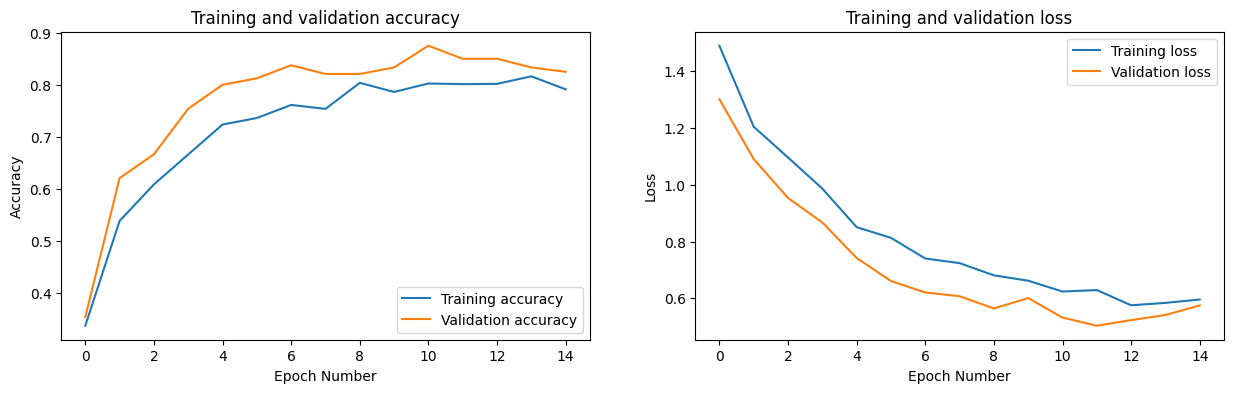

In [25]:
fig = plt.figure(figsize=(15,4))
print_history(history)

In [26]:
model.evaluate(
    x=[test_id, test_masks],
    y=Y_test,
    batch_size=16)

188/188 [==============================] - 338s 2s/step - loss: 0.4905 - accuracy: 0.8480


[0.4904754161834717, 0.8479999899864197]

In [21]:
history = model.fit(
    [text_id, text_masks], Y_train,
    batch_size = 16,
    verbose = 1,
    epochs=2,
    steps_per_epoch = 80)

Epoch 1/2
80/80 [==============================] - 183s 2s/step - loss: 0.5781 - accuracy: 0.8070
Epoch 2/2
80/80 [==============================] - 164s 2s/step - loss: 0.5348 - accuracy: 0.8258


In [22]:
model.evaluate(
    x=[test_id, test_masks],
    y=Y_test,
    batch_size=16)

188/188 [==============================] - 337s 2s/step - loss: 0.4199 - accuracy: 0.8683


[0.4198564887046814, 0.8683333396911621]

In [23]:
model.save_weights("bert")

In [26]:
model.load_weights("bert")